In [ ]:
## Imports
from PIL import Image,ImageFont,ImageDraw
import matplotlib.pyplot as plt
import praw
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords, reuters
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import wordcloud
import os 
import pickle
import numpy as np
import datetime
import IPython.display
import urllib.request, json 
import time
import os.path
import re
import pandas as pd
from collections import Counter
import configparser



#from dotenv import load_dotenv
#load_dotenv()


config = configparser.ConfigParser()
config.read('reddit.ini')

# Code to download corpora
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()




# do animation from now until...
min_end_date = datetime.datetime(2022,6,9)

# number of days per interval
days_step=3

# pushshift.  get data from now until ...
pushshift_max_date=int(time.time())
pushshift_min_date = time.mktime( (datetime.datetime.now() - datetime.timedelta(days=1)).timetuple() )



submissions_filename='submissions.pickle'




In [192]:
## Define function used to clean text data scrapped from a subreddit

#def lower_case
#    regex = re.compile("^[A-Z][a-z']+$")

stopwords_set = set()
for line in open('stopwords.txt'):
    stopwords_set.add(line.strip())
translateWords={}
with open('translate.json') as json_file:
    translateWords = json.load(json_file)    

def process_text_to_array(doc):
    doc = doc.replace("\\'","'").replace("’","'")
    
#    sw =  set(stopwords.words('english'))
    #print(sw)
##    sw.remove('like')
#    sw.remove('below')
#    sw.remove('above')
#    sw.remove('very')
#    sw.remove('against')
#    sw.remove('again')
#    sw.remove('ourselves')
##    sw.remove('himself')
#    sw.remove('yourself')
#    sw.remove('themselves')
#    sw.remove('herself')
#    sw.remove('himself')


#    sw.add('removed')
#    sw.add('deleted')
#    sw.add('celsius')
#    sw.add('was')
#    sw.add('also')
#    sw.add('get')
#    sw.add('got')
#    sw.add('day')
#    sw.add("im")
#    sw.add("id")
#    sw.add("ive")
#    sw.add("has")
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', doc)
    words = word_tokenize(re_clean)
    words = [word.lower() for word in words if (word.lower() not in stopwords_set and len(word)>=2) ]
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [((translateWords[word]) if word in translateWords else word.lower()) for word in lem if (word.lower() not in stopwords_set and len(word)>=2) ]
#    output = [word.lower() for word in lem if (word.lower() not in sw and len(word)>=2) ]
#    output = [word.lower() for word in lem]
    #print(Counter(output))
    return output
    

def process_text(doc):
    return text_array_to_string( rocess_text_to_array(doc))

def text_array_to_string(arr):
    return ' '.join(arr)

In [ ]:
## Load env variables. For this script to work, you'll have to have created an agent with reddit. Go to: https://www.reddit.com/prefs/apps, or google how to create a reddit agent
## You'll need a client_id, client_secret and a user agent name. Load them up as evn variables

default_config=config['DEFAULT']
c_id = default_config['C_ID']
c_secret = default_config['C_SECRET']
subreddit = default_config['C_SUBREDDIT']


if os.path.isfile(submissions_filename) :
    with open(submissions_filename, 'rb') as handle:
        submissions = pickle.load(handle)
else:
    submissions=[]


In [99]:
## Create data frame, call reddit function, ping user for subreddit's name and scrap the top 10 post



#subreddit = input('Enter subreddit name:')

def process_submission(submission):
    found = False
    for fsub in submissions:
        if fsub['submission'].id == submission.id:
            found = True
            break

    if found:
        print('skip:'+str(submission.id))
        return False
        
    print(datetime.datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d'), submission.title)
    submission.comments.replace_more(limit=0)
    comments = []
    for top_level_comment in submission.comments:
#        if isinstance(top_level_comment, praw.models.MoreComments):
#            continue
        comments.append(top_level_comment)
    print("comments:"+str(len(comments)))
    submissions.append({"submission":submission, "comments":comments})
    return True



In [ ]:

reddit = praw.Reddit(client_id=c_id,client_secret=c_secret,user_agent="wordcloud anim")    

#get submissions from praw reddit
#submissions = []
for submission in reddit.subreddit(subreddit).new(limit=1000):
    process_submission(submission)


In [ ]:
# get submissions from pushshift
# https://api.pushshift.io/reddit/submission/search/?after=1654863601&before=1656203081&sort_type=created_utc&sort=desc&subreddit=CelsiusNetwork&size=500



timeNum=pushshift_max_date

#timeNum = int( time.mktime( (datetime.datetime.now() - datetime.timedelta(days=30)).timetuple() ) )

pushshift_submission_ids_filename='pushshift_submission_ids.pickle'
#submission_ids=[]

if os.path.isfile(pushshift_submission_ids_filename):
    with open(pushshift_submission_ids_filename, 'rb') as handle:
        submission_ids = pickle.load(handle)
else:
    submission_id=[]

#timeNum=1656203081
#pushshift_min_date = time.mktime( (datetime.datetime.now() - datetime.timedelta(days=35)).timetuple() )

while timeNum>pushshift_min_date:
    with urllib.request.urlopen(
            "https://api.pushshift.io/reddit/submission/search/?after=1652421681&before="+
            str(timeNum)+
            "&sort_type=created_utc&sort=desc&subreddit=CelsiusNetwork&size=500") as url:
        data = json.loads(url.read().decode())
        #print(data)
        arr=data['data']
        #print(arr)
    if(len(arr)<=0):
        break
    timeNum = arr[len(arr)-1]['created_utc']
    for sub in arr:
        submission_ids.append(sub['id'])
    print('prev time:'+str(timeNum))

with open(pushshift_submission_ids_filename, 'wb') as handle:
    pickle.dump(submission_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
for sub_id in submission_ids:
    submission=reddit.submission(id=sub_id)
    process_submission(submission)
    

    

In [187]:




#with open('text.pickle', 'wb') as handle:
#    pickle.dump(text, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
with open(submissions_filename, 'wb') as handle:
    pickle.dump(submissions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [158]:

def get_arr_for_date(start, end):

    data = []
    for sub_obj in submissions:
        submission=sub_obj['submission']
        created = datetime.datetime.fromtimestamp(submission.created_utc)

        if(created < start or created > end):
            continue
        #print(created.strftime('%Y-%m-%d'), submission.title)
        data.append(submission.title)
        for comment in sub_obj['comments']:
            data.append(comment.body)
    ## Convert to text, clean data
    text = str(data)
    arr = process_text_to_array(text)

    return arr
#    print(text)
#    print(text_cleaned)

def get_string_for_date(start, end):
    return text_array_to_string(get_arr_for_date(start, end))



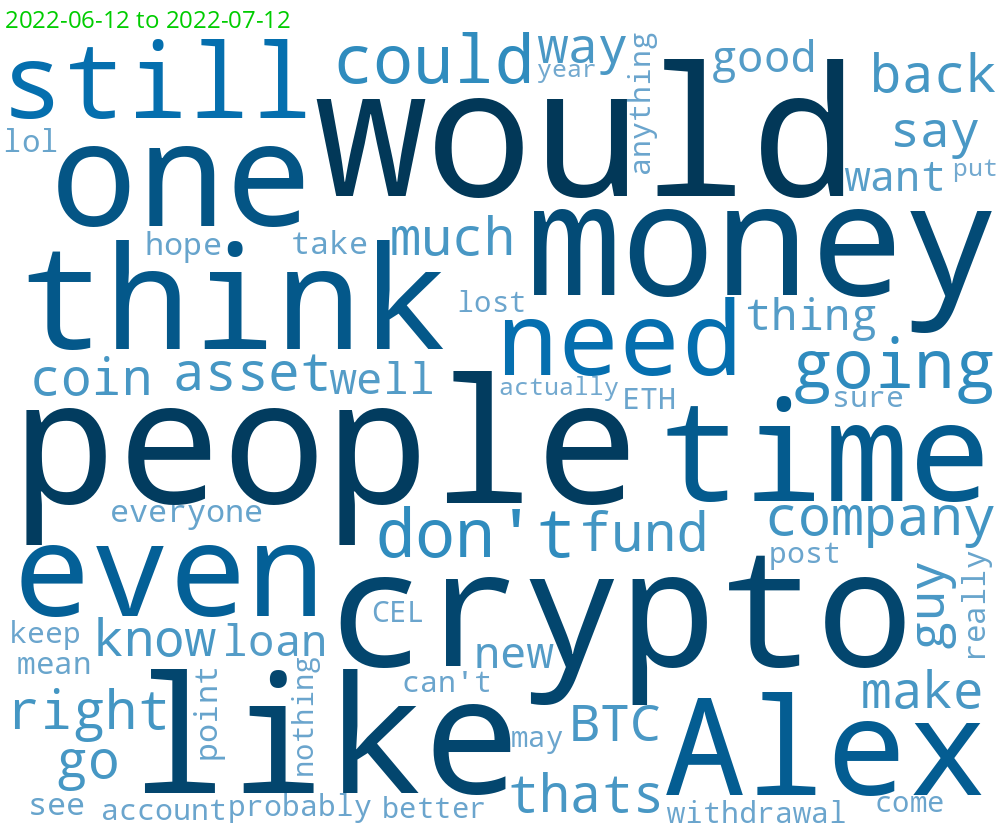

In [122]:
## Generate word cloud and save it to the same folder as this script is in. Thank you!! and have fun smiley face

min_font_size = 24
max_font_size = 180

def custom_color_func(colormap_name):
    colormap = plt.cm.get_cmap(colormap_name)
    def color_func(word=None, font_size=None, position=None,
                          orientation=None, font_path=None, random_state=None):
        color_scale = (font_size-min_font_size)/(max_font_size-min_font_size)
        r, g, b, _ = np.maximum(0, 255 * np.array(colormap(
            0.5+(color_scale*0.5)
        )))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)        
    return color_func
    

def do_word_cloud(text_cleaned, start_date, end_date):
    wc = WordCloud(background_color="white", max_words=3500, 
                   min_font_size=min_font_size,
                   max_font_size=max_font_size, 
                   random_state=42,
                   contour_width=5,
                   width=1000, height=800,
    #               colormap = "RdPu", #PuBu, bone, gnuplot
                   #color_func=wordcloud.get_single_color_func('#888888'),
                   color_func=custom_color_func("PuBu"),
                   stopwords=set()
                   )
    wc.generate(text_cleaned)

#    f = open("t.svg","w")
#    f.write(wc.to_svg())
#    f.close()
    
    start_str = start_date.strftime('%Y-%m-%d')
    date_str = start_str + ' to ' + end_date.strftime('%Y-%m-%d')

    #plt.rcParams['figure.figsize'] = [20, 5]
#    plt.rcParams['figure.dpi'] = 192
#    plt.imshow(wc.recolor(color_func=None),vmin=1000, interpolation="bilinear")
#    plt.figure(figsize=(1000,800))
    pngFile=start_str+'.png'
    wc.to_file(pngFile)
    
    im = Image.open(pngFile)
    font = ImageFont.truetype('/usr/share/fonts/TTF/OpenSans-Regular.ttf', 24) 
    img_with_text = Image.new(mode="RGB", size=(im.width, im.height+30), color="#ffffff")
    img_with_text.paste(im, (0,30))

    # drawing text size

    draw = ImageDraw.Draw(img_with_text)
    draw.text((5, 2), date_str, font = font, align ="left", fill="#00cc00")
    img_with_text.save(pngFile)
    IPython.display.display(IPython.display.Image(pngFile))#, width=1000, height=800)



end_date = datetime.datetime.now()
while min_end_date < end_date:
    #start_date = end_date - datetime.timedelta(days=3)
    start_date = min_end_date # TODO:
    text_cleaned = get_string_for_date(start_date, end_date)
    
    start_str = start_date.strftime('%Y-%m-%d')
    with open(start_str+'_range.txt', 'wb') as handle:
        pickle.dump(text_cleaned, handle, protocol=pickle.HIGHEST_PROTOCOL)
    do_word_cloud(text_cleaned, start_date, end_date)
    end_date = start_date
#<img src=“path_to_image/image.png”>
    

In [193]:
# process data into dateWords array for use in bar_chart_race

end_date = datetime.datetime.now()
end_date= end_date.replace(hour=23, minute=59, second=59)
datesWords=[]
wordsColumns={}
header=['Date']
dateIndex=0

allArr = get_arr_for_date(end_date - datetime.timedelta(days=999), end_date)
okWords={}
for k,v in Counter(allArr).items():
    if v>=100:
        okWords[k]=True

while min_end_date < end_date:
    start_date = end_date - datetime.timedelta(days=days_step)+datetime.timedelta(seconds=1)
    arr = get_arr_for_date(start_date, end_date)
    
    end_str = end_date.strftime('%Y-%m-%d')
    start_str = start_date.strftime('%Y-%m-%d')
    with open(end_str+'.txt', 'wb') as handle:
        handle.write(bytearray(text_array_to_string(arr),"utf8"))
    #header.append(start_str)
    wordsRow = [start_str + ' to ' +end_str]
    datesWords.append(wordsRow)
    
    for k,v in Counter(arr).items():
        if k not in okWords:
            continue
            
        col = len(header)
        if k not in wordsColumns:
            wordsColumns[k]=len(header)
            header.append(k)
        else:
            col = wordsColumns[k]
            
        while col>=len(wordsRow):
            wordsRow.append(0)
        wordsRow[col]=v
        
    end_date = start_date - datetime.timedelta(seconds=1)
    dateIndex = dateIndex +1
    
datesWords.reverse()    
datesWords2 = []
for row in datesWords:
    datesWords2.append(row)
    datesWords2.append(row)
    
    
import csv

# open the file in the write mode
with open('bar_chart.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(header)
    writer.writerows(datesWords)
#print(datesWords2)

#with open("bydate.csv","w") as csv:
#    csv.write((','.join(header)) +"\n")
#    for k,arr in wordsDates.items():
#        csv.write("%s,%s\n" % (k, ','.join(arr)))

/home/hankin/.local/lib/python3.10/site-packages/bar_chart_race/_make_chart.py:226: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


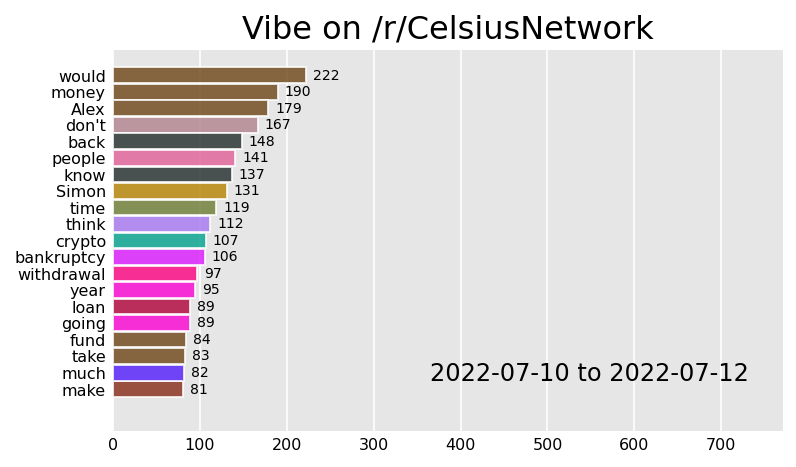

In [194]:
import bar_chart_race as bcr


# df = bcr.load_dataset('covid19_tutorial')
df = pd.DataFrame(datesWords2, columns=header)
df.set_index('Date', inplace=True)


# from...  https://github.com/dexplo/bar_chart_race/issues/42


#fig = plt.Figure(figsize=(6, 3.5), dpi=144)
#ax = fig.add_axes([0,0.2,1,1])

##### no title
# Set up a figure looking like bar_chart_race's default.
fig, ax = plt.subplots(figsize=(6, 3.5), dpi=144)
ax.set_facecolor('.9')
ax.tick_params(labelsize=8, length=0)
ax.grid(True, axis='x', color='white')
ax.set_axisbelow(True)
ax.set_title("Vibe on /r/CelsiusNetwork",fontsize=16)
ax.set_xlim(0, df.max().max() * 1.05 * 1.11)
[spine.set_visible(False) for spine in ax.spines.values()]

# Setting background to a solid color fixes the problem.
fig.patch.set_facecolor("white")

bcr.bar_chart_race(df, 
                   n_bars=20, 
                   steps_per_period=60,
                   period_length=2000,
#                   title="Vibe on /r/CelsiusNetwork",
                   #fixed_order=True,
                   fixed_max=True,
                   shared_fontdict={'family' : 'Noto Serif', 'color' : '.5'},
                   fig=fig,
                   filename="CelsiusWords.mp4"
                  )